<a href="https://colab.research.google.com/github/Samin-Sadaf7/Book-of-LLMs/blob/main/HandsOnLLM_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets>=2.18.0 transformers>=4.38.2 sentence-transformers>=2.5.1 setfit>=1.0.3 accelerate>=0.27.2 seqeval>=1.2.2

In [2]:
from datasets import load_dataset

# Prepare data and splits
tomatoes = load_dataset("rotten_tomatoes")
train_data, test_data = tomatoes["train"], tomatoes["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#Load model and tokenizer
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [20]:
from transformers import DataCollatorWithPadding

#Pad the longest sequence in the batch

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
  """Tokenize input data"""
  return tokenizer(examples['text'], truncation=True)

#tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [17]:
import numpy as np
import evaluate


def compute_metrics(eval_pred):
    """Calculate F1 score"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    load_f1 = evaluate.load("f1")
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"f1": f1}

In [ ]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-10-8f6c5e3dde62>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Step,Training Loss
500,0.403500


TrainOutput(global_step=534, training_loss=0.40082749713226207, metrics={'train_runtime': 118.3584, 'train_samples_per_second': 72.069, 'train_steps_per_second': 4.512, 'total_flos': 227605451772240.0, 'train_loss': 0.40082749713226207, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.36501193046569824,
 'eval_f1': 0.8507462686567164,
 'eval_runtime': 3.91,
 'eval_samples_per_second': 272.634,
 'eval_steps_per_second': 17.136,
 'epoch': 1.0}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels =2
)
tokenizer = AutoTokenizer.from_pretrained(model_id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
  print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [ ]:
for name, param in model.named_parameters():
  #Trainable Classification head
  if name.startswith("classifier"):
    param.requires_grad=True
  #Everything else freezed
  else:
    param.requires_grad=False

In [ ]:
# We can check whether the model was correctly updated
for name, param in model.named_parameters():
     print(f"Parameter: {name} ----- {param.requires_grad}")

Parameter: bert.embeddings.word_embeddings.weight ----- False
Parameter: bert.embeddings.position_embeddings.weight ----- False
Parameter: bert.embeddings.token_type_embeddings.weight ----- False
Parameter: bert.embeddings.LayerNorm.weight ----- False
Parameter: bert.embeddings.LayerNorm.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.query.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.query.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.key.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.key.bias ----- False
Parameter: bert.encoder.layer.0.attention.self.value.weight ----- False
Parameter: bert.encoder.layer.0.attention.self.value.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.weight ----- False
Parameter: bert.encoder.layer.0.attention.output.dense.bias ----- False
Parameter: bert.encoder.layer.0.attention.output.LayerNorm.weight ----- False
Parameter: bert.encoder.layer.0.attention.output

In [ ]:
from transformers import TrainingArguments, Trainer

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()

<ipython-input-17-1da7f8eeebcf>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.694700


TrainOutput(global_step=534, training_loss=0.6948552721002129, metrics={'train_runtime': 34.9747, 'train_samples_per_second': 243.891, 'train_steps_per_second': 15.268, 'total_flos': 227605451772240.0, 'train_loss': 0.6948552721002129, 'epoch': 1.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6825135946273804,
 'eval_f1': 0.64,
 'eval_runtime': 4.1777,
 'eval_samples_per_second': 255.165,
 'eval_steps_per_second': 16.038,
 'epoch': 1.0}

In [ ]:
# Load model
model_id = "bert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Encoder block 10 starts at index 165 and
# we freeze everything before that block
for index, (name, param) in enumerate(model.named_parameters()):
    if index < 165:
        param.requires_grad = False

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-389edc8581b7>:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.476100


{'eval_loss': 0.4100644588470459,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 3.7981,
 'eval_samples_per_second': 280.67,
 'eval_steps_per_second': 17.641,
 'epoch': 1.0}

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4100644588470459,
 'eval_f1': 0.8072519083969466,
 'eval_runtime': 3.8047,
 'eval_samples_per_second': 280.182,
 'eval_steps_per_second': 17.61,
 'epoch': 1.0}

In [ ]:
scores = []
for index in range(12):
     # Re-load model
     model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
     tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

     # Freeze encoder blocks 0-index
     for name, param in model.named_parameters():
         if "layer" in name:
             layer_nr = int(name.split("layer")[1].split(".")[1])
             if layer_nr <= index:
                 param.requires_grad = False
             else:
                 param.requires_grad = True

     # Train
     trainer = Trainer(
       model=model,
       args=training_args,
       train_dataset=tokenized_train,
       eval_dataset=tokenized_test,
       tokenizer=tokenizer,
       data_collator=data_collator,
       compute_metrics=compute_metrics,
     )
     trainer.train()

     # Evaluate
     score = trainer.evaluate()["eval_f1"]
     scores.append(score)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.405100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.406600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.408100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.411300


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.415100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.421800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.430100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.446200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.472200


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.518100


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-21-fb5a94417901>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.655600


In [ ]:
scores

[0.8467289719626169,
 0.8541862652869238,
 0.8528584817244611,
 0.8466603951081844,
 0.8388312912346843,
 0.839134524929445,
 0.8434864104967198,
 0.8358490566037736,
 0.8258801141769743,
 0.8164435946462715,
 0.7925270403146509,
 0.7058823529411765]

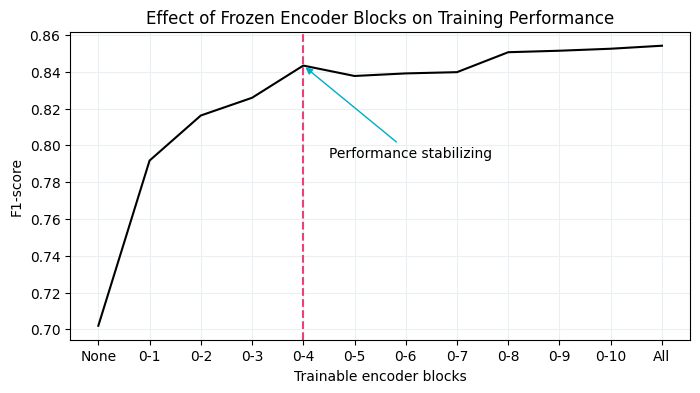

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create Figure
plt.figure(figsize=(8, 4))

# Prepare Data
x = [f"0-{index}" for index in range(12)]
x[0] = "None"
x[-1] = "All"
y = [
    0.8541862652869239,
    0.8525519848771267,
    0.8514664143803217,
    0.8506616257088847,
    0.8398104265402844,
    0.8391345249294448,
    0.8377358490566037,
    0.8433962264150944,
    0.8258801141769743,
    0.816247582205029,
    0.7917485265225934,
    0.7019400352733686
][::-1]

# Stylize Figure
plt.grid(color='#ECEFF1')
plt.axvline(x=4, color="#EC407A", linestyle="--")
plt.title("Effect of Frozen Encoder Blocks on Training Performance")
plt.ylabel("F1-score")
plt.xlabel("Trainable encoder blocks")

# Plot Data
plt.plot(x, y, color="black")

# Additional Annotation
plt.annotate(
    'Performance stabilizing',
    xy=(4, y[4]),
    xytext=(4.5, y[4] - .05),
    arrowprops=dict(
        arrowstyle="-|>",
        connectionstyle="arc3",
        color="#00ACC1")
)
plt.savefig("multiple_frozen_blocks.png", dpi=300, bbox_inches='tight')

In [ ]:
from setfit import sample_dataset
#We simulate a few shot setting by sampling 16 examples per class
sampled_train_data = sample_dataset(tomatoes["train"], num_samples=16)

In [ ]:
from setfit import SetFitModel

#Load a pretrained SentenceTransformer model
model = SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [ ]:
from setfit import TrainingArguments as SetFitTraingingArguments
from setfit import Trainer as SetFitTrainer

#Define training arguments
args = SetFitTraingingArguments(
    num_iterations=20, #number of text pairs to generate
    num_epochs=3, #the number of epochs to use for contrastive learning
)
args.eval_strategy = args.evaluation_strategy

#Create trainer
trainer = SetFitTrainer(
    model=model,
    args=args,
    train_dataset=sampled_train_data,
    eval_dataset=test_data,
    metric="f1"
)

trainer.train()

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.845703125}

In [ ]:
from setfit import SetFitTrainer
# Create trainer
trainer = SetFitTrainer(
     model=model,
     train_dataset=sampled_train_data,
     eval_dataset=test_data,
     metric="f1",
     num_epochs=3, # The number of epochs to use for contrastive learning
)

<ipython-input-26-a51ab963225a>:3: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

In [ ]:
#Training Loop
trainer.train()

***** Running training *****
  Num unique pairs = 1280
  Batch size = 16
  Num epochs = 3


Step,Training Loss
1,0.308300
50,0.118500
100,0.001100
150,0.000400
200,0.000300


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

In [ ]:
#Evaluate
trainer.evaluate()

***** Running evaluation *****


{'f1': 0.845703125}

In [ ]:
model.model_head

LogisticRegression()

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

#Load model for masked language modeling(MLM)
model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [4]:
def preprocess_function(examples):
  """Tokenize input data"""
  return tokenizer(examples['text'], truncation=True)

#Tokenize data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_train = tokenized_train.remove_columns("label")
tokenized_test = test_data.map(preprocess_function, batched=True)
tokenized_test = tokenized_test.remove_columns("label")

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [5]:
from transformers import DataCollatorForLanguageModeling

#Pad the longest sequence in the batch
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
  )

In [7]:
from transformers import TrainingArguments, Trainer
#Training arguments for parameter tuning
training_args = TrainingArguments(
    "model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none"
)
#initialze trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-7-0eac5d0e26c5>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [8]:
#Save pretrained tokenizer
tokenizer.save_pretrained("mlm")

('mlm/tokenizer_config.json',
 'mlm/special_tokens_map.json',
 'mlm/vocab.txt',
 'mlm/added_tokens.json',
 'mlm/tokenizer.json')

In [9]:
#Train model
trainer.train()

Step,Training Loss
500,2.604200
1000,2.371300
1500,2.306600
2000,2.190800
2500,2.149400
3000,2.089100
3500,2.053200
4000,1.993300
4500,1.986600
5000,1.955400


TrainOutput(global_step=5340, training_loss=2.156930633430624, metrics={'train_runtime': 1256.4501, 'train_samples_per_second': 67.89, 'train_steps_per_second': 4.25, 'total_flos': 2273819807394096.0, 'train_loss': 2.156930633430624, 'epoch': 10.0})

In [10]:
#Save updated model
model.save_pretrained("mlm")

In [13]:
from transformers import pipeline

# Load and create predictions
mask_filler = pipeline("fill-mask", model="bert-base-cased")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


>>> What a horrible idea!
>>> What a horrible dream!
>>> What a horrible thing!
>>> What a horrible day!
>>> What a horrible thought!


In [14]:
# Load and create predictions
mask_filler = pipeline("fill-mask", model="mlm")
preds = mask_filler("What a horrible [MASK]!")

# Print results
for pred in preds:
    print(f">>> {pred['sequence']}")

Device set to use cuda:0


>>> What a horrible movie!
>>> What a horrible film!
>>> What a horrible mess!
>>> What a horrible comedy!
>>> What a horrible story!


In [21]:
from transformers import AutoModelForSequenceClassification

#Finetune for classification
model = AutoModelForSequenceClassification.from_pretrained(
    "mlm", num_labels=2
)
tokenizer = AutoTokenizer.from_pretrained("mlm")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mlm and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import DataCollatorWithPadding

#Pad the longest sequence in the batch

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def preprocess_function(examples):
  """Tokenize input data"""
  return tokenizer(examples['text'], truncation=True)

#tokenize train/test data
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [23]:
from transformers import TrainingArguments, Trainer

# Training arguments for parameter tuning
training_args = TrainingArguments(
   "model",
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=1,
   weight_decay=0.01,
   save_strategy="epoch",
   report_to="none"
)

# Trainer which executes the training process
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

<ipython-input-23-8f6c5e3dde62>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [24]:
#train model
trainer.train()

Step,Training Loss
500,0.379800


TrainOutput(global_step=534, training_loss=0.37790426690033757, metrics={'train_runtime': 112.6427, 'train_samples_per_second': 75.726, 'train_steps_per_second': 4.741, 'total_flos': 227605451772240.0, 'train_loss': 0.37790426690033757, 'epoch': 1.0})

In [25]:
#Evaluate model
trainer.evaluate()

{'eval_loss': 0.35641050338745117,
 'eval_f1': 0.8450704225352113,
 'eval_runtime': 3.8364,
 'eval_samples_per_second': 277.865,
 'eval_steps_per_second': 17.464,
 'epoch': 1.0}